In [1]:
# Import required modules
import cv2
import pandas as pd
from PIL import Image
import numpy as np
import os
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import matplotlib.pyplot as plt

In [2]:
# Load data from data in .xlsx files
test_data_pixel_info = pd.read_csv(r"C:\Users\dhyut\SEM 7\sign_language_detector\ds\sign_mnist_test\sign_mnist_test.csv")
train_data_pixel_info = pd.read_csv(r"C:\Users\dhyut\SEM 7\sign_language_detector\ds\sign_mnist_train\sign_mnist_train.csv")

In [3]:
# Function to generate a 28x28 grayscale image from given pixel values
def generate_image(arr, i):
    arr = np.array(arr)
    label = arr[0]
    image = []

    # 28 x 28
    row_data = []
    for i in range(1, len(arr)):
        row_data.append(int(arr[i]))
    
        if((i)%28 == 0):
            row_data = np.array(row_data)
            image.append(row_data)
            row_data = []
        
    image = np.array(image, dtype=np.uint8) 
    new_image = Image.fromarray(image)
    new_image.save('new.png')
    img = cv2.imread('new.png', 0)
    return (label, img)

# Function to generate the test and train datasets from given pixel data
def generate_dataset(csv_file):
    ds = []
    for i in range(5000):
        image = generate_image(csv_file.iloc[i], i)
        ds.append(image)
    return ds


In [4]:
# Generate Test and Train dataset
test_data = generate_dataset(test_data_pixel_info)
train_data = generate_dataset(train_data_pixel_info)

train_label = []
test_label =  []
test_dataa = []
train_dataa = []

for i in range(len(train_data)):
    train_label.append(train_data[i][0])
    train_dataa.append(train_data[i][1])
    
for i in range(len(test_data)):
    test_label.append(test_data[i][0])
    test_dataa.append(test_data[i][1])

In [15]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


img = cv2.imread('new.png', 0)
image_x = img.shape[0]
image_y = img.shape[1]

# CNN 
def cnn_model():
	num_of_classes = 25
	model = Sequential()
    
    # 1. Convolution
	model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
    
    # 2. Batch Normalization
	model.add(BatchNormalization())
    
    # 3. Max pooling
	model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    # 4. Convolution
	model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    
	model.add(Dropout(0.2))
    
    # 5. Batch Normalization
	model.add(BatchNormalization())
    
    # 6. Max Pooling
	model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    # 7. Convolution
	model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    
    # 8. Batch Normalization
	model.add(BatchNormalization())
    
    # 9. Max Pooling
	model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    # 10. Flatten
	model.add(Flatten())
    
    # 11. Hidden Layer
	model.add(Dense(units = 512 , activation = 'relu'))
	model.add(Dropout(0.3))
    
    # 12. Output Layer
	model.add(Dense(units = 25 , activation = 'softmax'))
    
    # Compile all the layers
	model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    
	filepath="cnn_model_keras2.h5"
    
	checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
	callbacks_list = [checkpoint1]
    
	return model, callbacks_list


def train():
    
	train_images = np.array(train_dataa, dtype=np.int32)
	train_labels = np.array(train_label, dtype=np.int32)

	val_images = np.array(test_dataa, dtype=np.int32)
	val_labels = np.array(test_label, dtype=np.int32)

	train_images = np.reshape(np.array(train_images), (train_images.shape[0], image_x, image_y, 1))
	val_images = np.reshape(np.array(val_images), (val_images.shape[0], image_x, image_y, 1))
	train_labels = np_utils.to_categorical(train_labels)
	val_labels = np_utils.to_categorical(val_labels)

	model, callbacks_list = cnn_model()
	model.summary()
	fit_model = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=15, batch_size=128, callbacks=callbacks_list)
	scores = model.evaluate(val_images, val_labels, verbose=0)
    
	print("CNN Error: %.2f%%" % (100-scores[1]*100))
	print("CNN Accuracy: %.2f%%" % (100 - (100-scores[1]*100)))
	model.save('cnn_model_keras2.h5')
	return fit_model, model

final_model, model = train()
K.clear_session();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

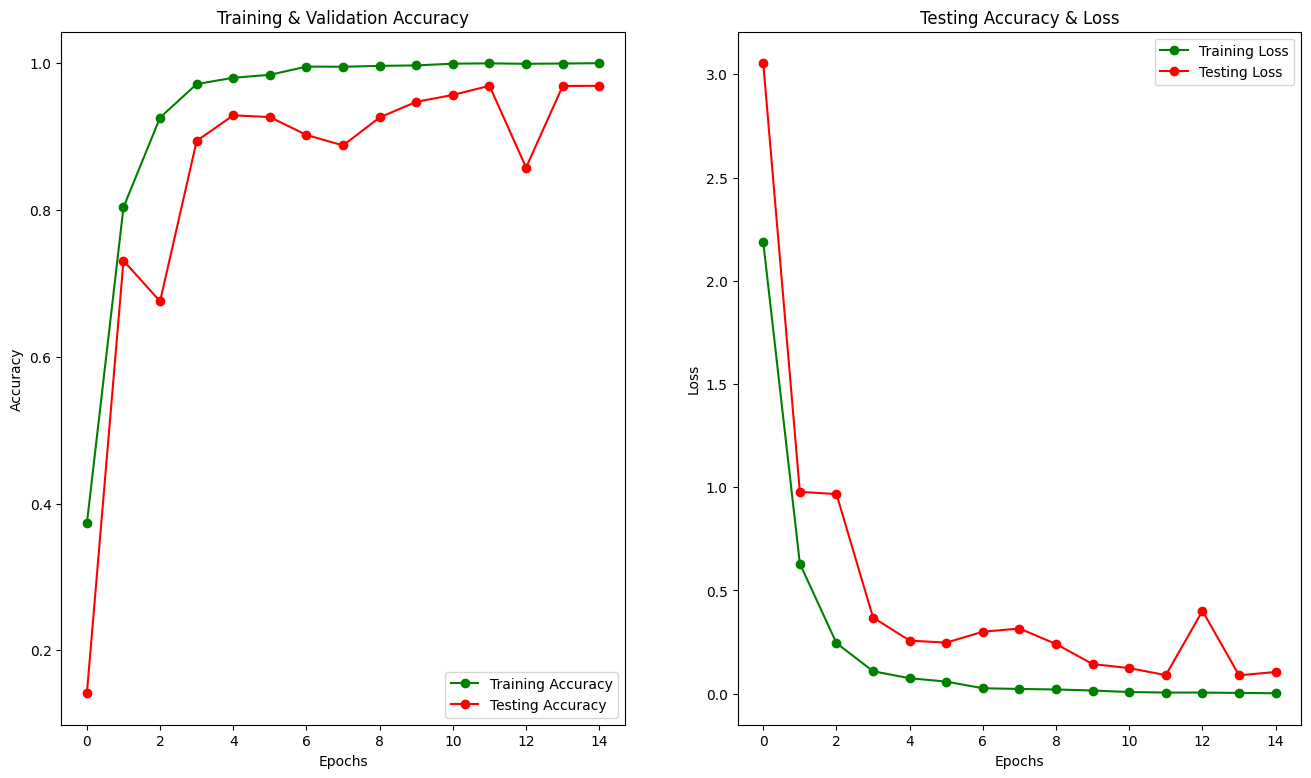

In [16]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = final_model.history['accuracy']
train_loss = final_model.history['loss']
val_acc = final_model.history['val_accuracy']
val_loss = final_model.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()